## Import Packages

Install [pandasql](https://github.com/yhat/pandasql/) to query `pandas` DataFrames using [SQLite syntax](https://www.sqlite.org/lang.html).  It works similarly to [sqldf](https://github.com/ggrothendieck/sqldf) in `R`.

In [ ]:
!pip install pandasql

Install [igraph](https://igraph.org/python/) to process and model the network data.

In [ ]:
!pip install igraph

Import [NetworkX](https://networkx.org/documentation/stable/tutorial.html), [igraph](https://igraph.org/python/), and some additional packages to process and plot the network data.

In [56]:
import datetime
import json

import numpy as np
import pandas as pd
from pandasql import sqldf

import igraph as ig
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import community

import matplotlib as mpl
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')
import seaborn as sns

from IPython.display import Image, display
pd.options.display.max_rows = 100
# pd.options.display.precision = 15
# pd.options.display.float_format = '{:.2f}%'.format

# Network Modeling

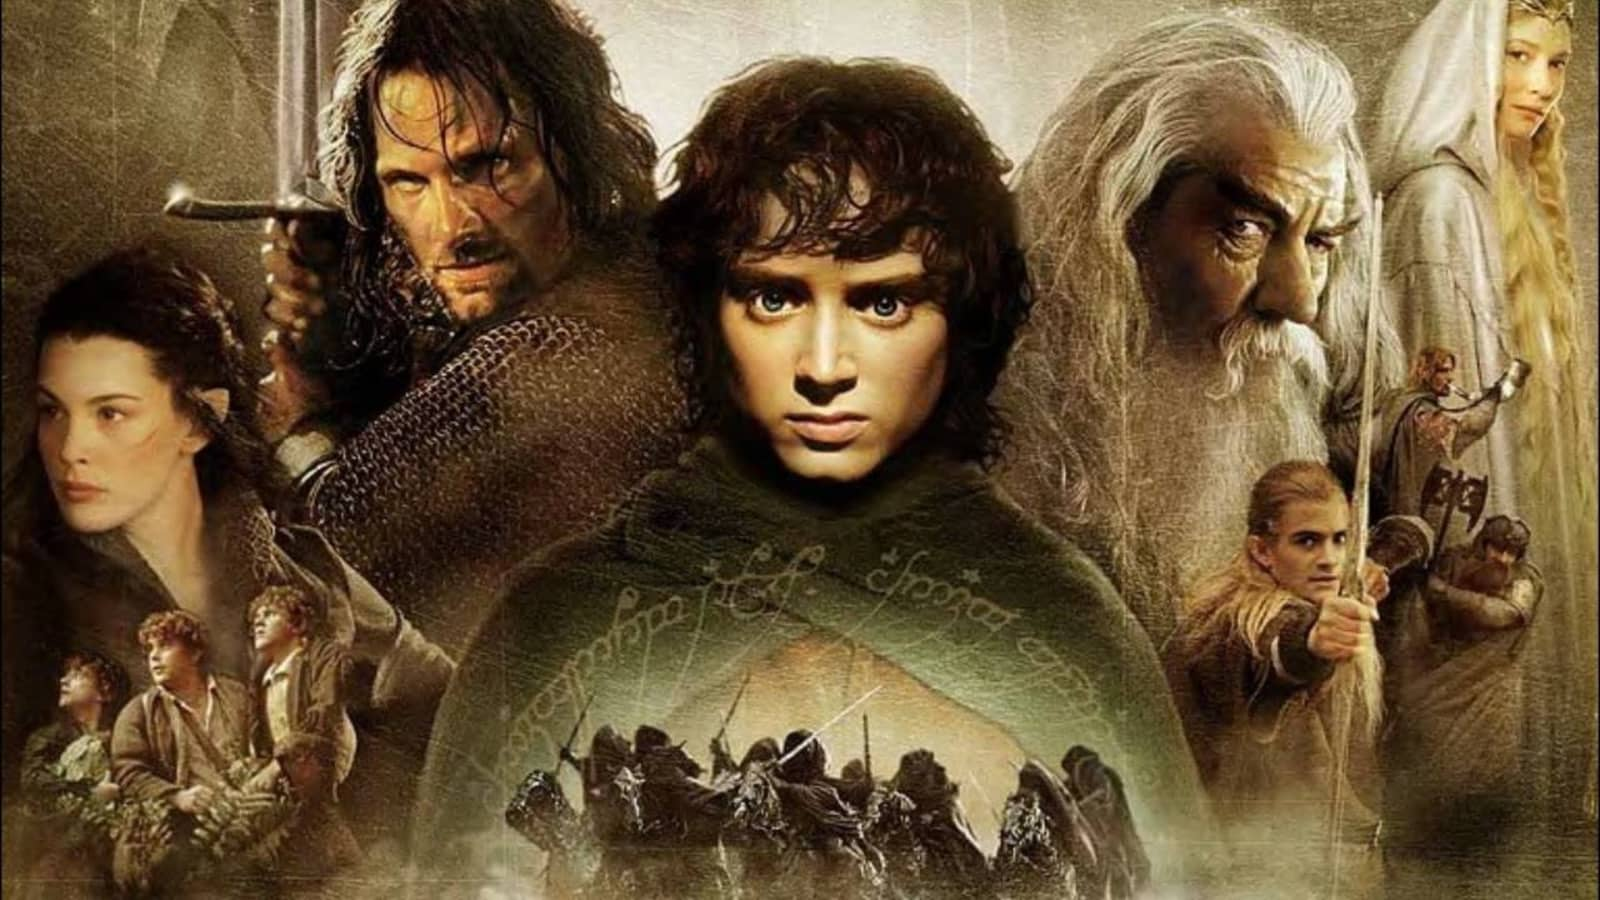

## Read Data

### Ontology

Read CSV data from the `morethanbooks` [Lord of the Rings Networks](https://github.com/morethanbooks/projects/tree/master/LotR) repository into a `pandas` DataFrame.  
`ontology.csv` contains the basic metadata about each entity (i.e. proper names used to reference characters, places, or groups) together with its identifier (e.g. the identifier for Aragorn is "arag").

In [57]:
ontology = pd.read_csv('https://raw.githubusercontent.com/morethanbooks/projects/master/LotR/ontologies/ontology.csv', sep='\t')
ontology.columns = ['id', 'type', 'label', 'freqsum', 'subtype', 'gender']
ontology.head()

,id,type,label,freqsum,subtype,gender
0,andu,pla,Anduin,109,pla,NaN
1,arag,per,Aragorn,1069,men,male
2,arat,per,Arathorn,36,men,male
3,arwe,per,Arwen,51,elves,female
4,bage,pla,Bag End,77,pla,NaN


### Books 1, 2, 3 Combined

Read CSV data from the `morethanbooks` [Lord of the Rings Networks](https://github.com/morethanbooks/projects/tree/master/LotR) repository into a `pandas` DataFrame.

`networks-id-3books.csv` contains an edges table with the number of times two entities are mentioned in the same paragraph across all three books of the series.

In this project, the nodes represent entities (i.e. proper names used to reference characters, places, or groups), and two of them are connected by an edge if in any paragraph there are references to these two entities.

Across the three books, Frodo and Sam are referenced in the same paragraph most frequently (533 paragraphs), and Frodo and Gandalf are referenced in the second most number of paragraphs(181 paragraphs).

In [58]:
books123 = pd.read_csv('https://raw.githubusercontent.com/morethanbooks/projects/master/LotR/tables/networks-id-3books.csv')
books123['Type'] = 'Books 123'
books123.columns = ['source', 'target', 'weight', 'volume']
books123.head()

,source,target,weight,volume
0,frod,sams,533,Books 123
1,frod,ganda,181,Books 123
2,merr,pipp,162,Books 123
3,arag,frod,146,Books 123
4,frod,goll,127,Books 123


## Create a DataFrame from the `books123` edgelist for an undirected graph

We can use `sqldf` to create a `pandas` DataFrame that combines the edges data from `books123` and the metadata about the entities from `ontology`.  The result is a DataFrame with all of the information we have about the paragraph references to pairs of entities across all three books.

In [59]:
network_df = sqldf("""
    SELECT 
      sour.id AS source_id, sour.label as source_name, sour.type AS source_type, sour.subtype AS source_subtype, sour.gender AS source_gender,
      dest.id AS target_id, dest.label AS target_name, dest.type AS target_type, dest.subtype AS target_subtype, dest.gender AS target_gender,
      conn.weight, conn.volume
    FROM 
      books123 conn 
      JOIN ontology sour
      ON
        conn.source = sour.id
      JOIN ontology dest
      ON  
        conn.target = dest.id
""")

network_df.weight = network_df.weight.astype('int')

network_df.loc[((network_df.source_name.isin(['Frodo'])) | (network_df.target_name.isin(['Frodo']))) & (network_df.source_type == 'per') & (network_df.target_type == 'per'), :].sort_values(by=['source_id', 'weight'], ascending=[True, False])

,source_id,source_name,source_type,source_subtype,source_gender,target_id,target_name,target_type,target_subtype,target_gender,weight,volume
3,arag,Aragorn,per,men,male,frod,Frodo,per,hobbit,male,146,Books 123
876,arat,Arathorn,per,men,male,frod,Frodo,per,hobbit,male,2,Books 123
488,arwe,Arwen,per,elves,female,frod,Frodo,per,hobbit,male,6,Books 123
642,bali,Balin,per,dwarf,male,frod,Frodo,per,hobbit,male,4,Books 123
1124,bere,Beregond,per,men,male,frod,Frodo,per,hobbit,male,1,Books 123
5,bilb,Bilbo,per,hobbit,male,frod,Frodo,per,hobbit,male,126,Books 123
368,bill,Bill,per,animal,male,frod,Frodo,per,hobbit,male,9,Books 123
19,boro,Boromir,per,men,male,frod,Frodo,per,hobbit,male,68,Books 123
1160,cele,Celeborn,per,elves,male,frod,Frodo,per,hobbit,male,1,Books 123
443,dene,Denethor,per,men,male,frod,Frodo,per,hobbit,male,7,Books 123


## Create a network graph of people with edge weights greater than 20

[NetworkX](https://networkx.org/documentation/stable/index.html) has many functions for [reading and writing graphs](https://networkx.org/documentation/stable/reference/readwrite/index.html) and [converting to and from other data formats](https://networkx.org/documentation/stable/reference/convert.html).  We can create a network graph `G` from a `pandas` DataFrame using NetworkX's [`from_pandas_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) function.

In [60]:
people_of_interest_df = network_df[(network_df['source_type'] == 'per') & (network_df['target_type'] == 'per') & (network_df['weight'] > 20)]

G = nx.from_pandas_edgelist(
        people_of_interest_df,
        source="source_name",
        target="target_name",
        edge_attr=["weight"],
        create_using=nx.Graph(),
    )

G

## Add gender and subtype attributes and colors to the nodes

Determine the unique genders in the dataset

In [61]:
genders = sorted(list(network_df.loc[network_df.source_type == 'per', 'source_gender'].unique()))
genders

['female', 'male']

Associate the unique genders with colors

In [62]:
gender_colormap = { 'female': 'darkorange', 'male': 'blue' }
gender_colormap

{'female': 'darkorange', 'male': 'blue'}

Determine the unique subtypes in the dataset

In [63]:
subtypes = sorted(list(network_df.loc[network_df.source_type == 'per', 'source_subtype'].unique()))
subtypes

['ainur', 'animal', 'dwarf', 'elves', 'ents', 'hobbit', 'men', 'orcs']

Associate the unique subtypes with colors

In [64]:
subtype_colormap = { 'ainur': 'tab:blue', 'animal': 'tab:orange', 'dwarf': 'tab:green', 'elves': 'tab:red', 'ents': 'tab:purple', 'hobbit': 'tab:brown', 'men': 'tab:pink', 'orcs': 'tab:cyan' }
subtype_colormap

{'ainur': 'tab:blue',
 'animal': 'tab:orange',
 'dwarf': 'tab:green',
 'elves': 'tab:red',
 'ents': 'tab:purple',
 'hobbit': 'tab:brown',
 'men': 'tab:pink',
 'orcs': 'tab:cyan'}

Create a dictionary that associates each node (person) with four new attributes for that person

In [65]:
attrs = {}
for row in network_df.loc[network_df.source_type == 'per', :].itertuples(index=False):
    if row.source_name not in attrs:
        attrs[row.source_name] = {'subtype': row.source_subtype, 
                                  'subtype_color': subtype_colormap[row.source_subtype], 
                                  'gender': row.source_gender, 
                                  'gender_color': gender_colormap[row.source_gender] }

len(attrs)

42

Assign the attributes to the nodes in the network

In [66]:
nx.set_node_attributes(G, attrs)

### Check that the attributes were added to the nodes

In [67]:
# G.nodes.data()
[(n, G.nodes[n]) for n in G.nodes()]

[('Frodo',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Sam',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Gandalf',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'ainur',
   'subtype_color': 'tab:blue'}),
 ('Merry',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Pippin',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Aragorn',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'men',
   'subtype_color': 'tab:pink'}),
 ('Gollum',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Bilbo',
  {'gender': 'male',
   'gender_color': 'blue',
   'subtype': 'hobbit',
   'subtype_color': 'tab:brown'}),
 ('Gimli',
  {'gender': 'male',
   'gender_color': 'blue',

# Statistical Analysis of Network Data with R, 2nd Edition, by Kolaczyk and Csardi

The following analyses are adapted from the book, [Statistical Analysis of Network Data with R, 2nd Edition](https://github.com/kolaczyk/sand), by Eric Kolaczyk and Gabor Csardi, to analyze the LotR network.

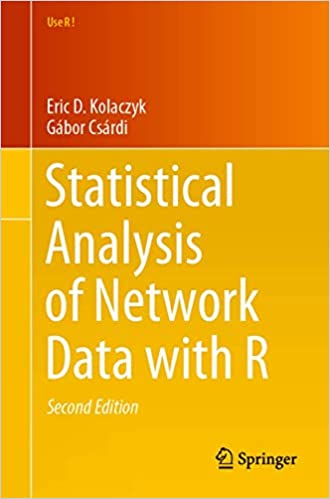

# Partitioning the `LotR` Network into Communities

Using an agglomerative hierarchical clustering algorithm, implemented in `NetworkX` as `greedy_modularity_communities`, to determine the number of communities in the network, we identify 6 communities in the `LotR` network.

In [68]:
# Identify communities in the network using an agglomerative hierarchical clustering algorithm
lotr_c = community.greedy_modularity_communities(G, weight=None)
lotr_c

[frozenset({'Gandalf',
            'Saruman',
            'Sauron',
            'Shadowfax',
            'Théoden',
            'Treebeard',
            'Éomer',
            'Éowyn'}),
 frozenset({'Bilbo', 'Bill', 'Bombadil', 'Frodo', 'Gollum', 'Sam'}),
 frozenset({'Aragorn', 'Arathorn', 'Arwen', 'Elendil', 'Elrond', 'Isildur'}),
 frozenset({'Beregond', 'Boromir', 'Denethor', 'Faramir', 'Pippin'}),
 frozenset({'Gimli', 'Glóin', 'Legolas', 'Merry'}),
 frozenset({'Celeborn', 'Galadriel'})]

In [69]:
# Number of communities
len(lotr_c)

6

In [70]:
# Number of nodes (people) in each of the communities
[len(community) for community in lotr_c]

[8, 6, 6, 5, 4, 2]

In [71]:
# Display the community numbers and the nodes (people) in each of the communities
[(idx, person) for idx, community in enumerate(lotr_c) for person in community]

[(0, 'Treebeard'),
 (0, 'Éowyn'),
 (0, 'Shadowfax'),
 (0, 'Saruman'),
 (0, 'Théoden'),
 (0, 'Gandalf'),
 (0, 'Éomer'),
 (0, 'Sauron'),
 (1, 'Frodo'),
 (1, 'Bilbo'),
 (1, 'Bill'),
 (1, 'Sam'),
 (1, 'Bombadil'),
 (1, 'Gollum'),
 (2, 'Isildur'),
 (2, 'Elendil'),
 (2, 'Aragorn'),
 (2, 'Arathorn'),
 (2, 'Elrond'),
 (2, 'Arwen'),
 (3, 'Beregond'),
 (3, 'Pippin'),
 (3, 'Denethor'),
 (3, 'Boromir'),
 (3, 'Faramir'),
 (4, 'Gimli'),
 (4, 'Legolas'),
 (4, 'Merry'),
 (4, 'Glóin'),
 (5, 'Galadriel'),
 (5, 'Celeborn')]

## Plot the nodes and edges of the LotR network (color nodes by community)

In [72]:
# Identify the communities and centralities of the nodes (people)
communities = list(community.greedy_modularity_communities(G, weight=None))
community_colormap = { '0': 'tab:blue', '1': 'tab:orange', '2': 'tab:green', '3': 'tab:red', '4': 'tab:purple', '5': 'tab:brown', '6': 'tab:pink', '7': 'tab:cyan' }

centralities = nx.degree_centrality(G)

for f in G.nodes():
  for i, c in enumerate(communities):
    if f in c:
      G.nodes[f].update({
          "community" : str(i),
          'community_color' : community_colormap[str(i)],
          "centrality" : centralities[f],
          })

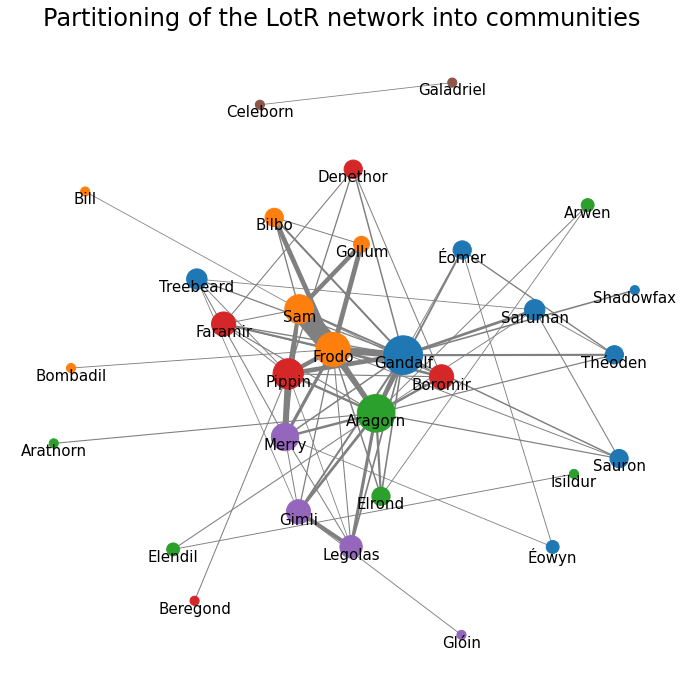

In [73]:
# Plot the LotR network (color nodes by community and size them by centrality)
plt.figure(figsize=(12,12))

pos = nx.layout.spring_layout(G, k=4, seed=11)

node_colors = [nodedata['community_color'] for _, nodedata in G.nodes(data=True)]
node_sizes = [nodedata['centrality']*2500 for _, nodedata in G.nodes(data=True)]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

unique_weights = network_df['weight'].unique()
for weight in unique_weights:
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight*20/max(unique_weights)
    nx.draw_networkx_edges(G, pos, edgelist=weighted_edges, width=width, alpha=1, edge_color='grey')

labels = nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif', verticalalignment='top')

ax = plt.gca()
ax.set_axis_off()

plt.title('Partitioning of the LotR network into communities', size=24)
plt.show()

# Assessing the Number of Communities in a Network 

We identified 6 communities in the `LotR` network using an agglomerative hierarchical clustering algorithm.  Is this number of communities unexpected or unusual?  To assess whether this number of communities is unusual, let's compare this empirical outcome to the number of communities we find in random graphs that have similar properties to the `LotR` network:

1) Graphs that have the same number of nodes (31) and edges (79) as the `LotR` network

2) Graphs that have the further restriction that they have the same degree distribution as the `LotR` network

Using Monte Carlo methods, we can assess whether the number of communities we identified in the `LotR` network is unusual or to be expected by comparing it to the number of communities we identify in random graphs with similar properties.

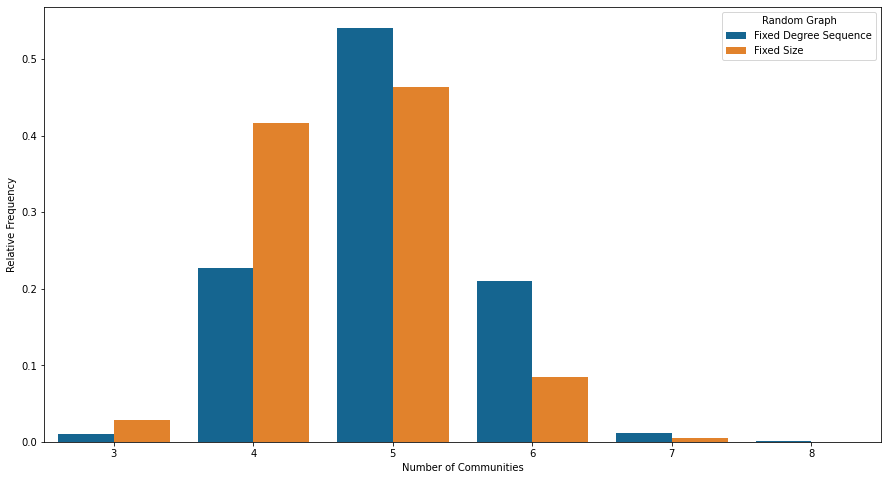

In [74]:
# Number of nodes
nv = nx.number_of_nodes(G)
# Number of edges
ne = nx.number_of_edges(G)

# Calculate the degree of each node
degs = [tup[1] for tup in sorted([(node, G.degree(node)) for node in G.nodes], key=lambda item: -item[1])]

# Number of MC trials
ntrials = 1000

# Calculate the number of communities across 1000 "G(n,m)" random graphs
num_comm_rg = [None] * ntrials
for i in range(ntrials):
  g_rg = nx.gnm_random_graph(nv, ne) # Returns a G(n,m) random graph
  c_rg = community.greedy_modularity_communities(g_rg, weight=None)
  num_comm_rg[i] = len(c_rg)

# Calculate the number of communities across 1000 "G(n,m) + same degree distribution" random graphs
num_comm_grg = [None] * ntrials
for i in range(ntrials):
  Gnm = nx.gnm_random_graph(nv, ne) # Returns a G(n,m) random graph
  g_grg = nx.configuration_model(degs, create_using=Gnm) # Returns a MultiGraph with the specified degree sequence
  g_grg = nx.Graph(g_grg) # Remove any parallel edges from the returned graph
  g_grg.remove_edges_from(nx.selfloop_edges(g_grg)) # Remove any self-loops
  c_grg = community.greedy_modularity_communities(g_grg, weight=None)
  num_comm_grg[i] = len(c_grg)

# Calculate the proportion of trials with each Number of Communities
# both for the Fixed Size graphs and the Fixed Degree Sequence graphs
indx = (['Fixed Size'] * ntrials) + (['Fixed Degree Sequence'] * ntrials)
rslts = num_comm_rg + num_comm_grg
df = pd.DataFrame(zip(indx,rslts), columns=['Random Graph', 'Communities'])

counts = df.groupby(by=['Communities', 'Random Graph']).size().reset_index(name='Counts')
freqs  = counts.pivot_table(index='Random Graph', columns='Communities', values='Counts', fill_value=0).apply(lambda val: val / val.sum(), axis=1).unstack().reset_index()
freqs.columns = ['Number of Communities', 'Random Graph', 'Relative Frequency']

# Plot the proportion of trials with each Number of Communities
# both for the Fixed Size graphs and the Fixed Degree Sequence graphs
plt.figure(figsize = (15,8))
sns.barplot(x='Number of Communities', y='Relative Frequency', hue='Random Graph', data=freqs);

Based on this analysis, the number of communities we identified in the `LotR` network (**6**) is slightly higher than to the number we would expect to find based on random graphs with similar properties, expecially random graphs of fixed size.  The results suggest there are likely additional processes at work in the `LotR` network that go beyond simply the density and distribution of social interactions in the network.

# Assessing Small World Properties of a Network

A typical approach to assessing small-world properties is to compare the observed clustering coefficient and average (shortest) path length in an observed network to what might be observed in an appropriately calibrated random graph.  Under such a comparison, if the observed network exhibits small-world properties, we should expect to see that the observed clustering coefficient exceeds that of a random graph, while the average path length remains roughly the same.

In [75]:
# Number of nodes
nv = nx.number_of_nodes(G)
# Number of edges
ne = nx.number_of_edges(G)

# Number of MC trials
ntrials = 1000

# Calculate global transitivity and average path length
# for connected "G(n,m)" random graphs
cl_rg = pd.Series([None] * ntrials).astype('float')
apl_rg = pd.Series([None] * ntrials).astype('float')
for i in range(ntrials):
  g_rg = nx.gnm_random_graph(nv, ne) # Returns a G(n,m) random graph
  if nx.is_connected(g_rg): # if connected
    cl_rg[i]  = nx.transitivity(g_rg)
    apl_rg[i] = nx.average_shortest_path_length(g_rg, weight=None)
  else: # if not connected, analyze largest connected component
    largest_cc = max(nx.connected_components(g_rg), key=len)
    conn_comp = g_rg.subgraph(largest_cc).copy()
    cl_rg[i]  = nx.transitivity(conn_comp)
    apl_rg[i] = nx.average_shortest_path_length(conn_comp, weight=None)    

# Global transitivity: random graph (weights nodes with large degree higher than average clustering)
print(pd.DataFrame(cl_rg.describe()).round(3).T)
print('')

# Global transitivity: LotR network (weights nodes with large degree higher than average clustering)
print(round(nx.transitivity(G), 3))
print('')

# Average path length: random graph
print(pd.DataFrame(apl_rg.describe()).round(3).T)
print('')

# Average path length: Largest connected component of the LotR network
largest_cc = max(nx.connected_components(G), key=len)
conn_comp = G.subgraph(largest_cc).copy()
print(round(nx.average_shortest_path_length(conn_comp), 3))

    count   mean   std    min    25%    50%    75%    max
0  1000.0  0.166  0.03  0.082  0.146  0.165  0.186  0.256

0.453

    count   mean    std    min    25%    50%    75%    max
0  1000.0  2.211  0.038  2.047  2.187  2.211  2.234  2.357

2.131


Here we find that the observed `LotR` network exhibits small-world properties, namely, the observed clustering coefficient (0.45) exceeds that of a random graph, while the average path length (2.13) remains roughly the same.

# Exponential Random Graph Models (ERGMs)

Exponential Random Graph Models (ERGMs) are a general class of models based in exponential-family theory, analogous to classical generalized linear models (GLMs), for specifying the probability distribution for a set of random graphs or networks.  Like GLMs, ERGMs are flexible -- for instance, it's possible to include variables representing features like homophily, triad effects, and a range of other features of interest, such as the attributes of people in a social network.  However, some of the theoretical frameworks underlying GLMs hasn't been formally justified for ERGMs, so they should be used and interpreted carefully.

The general form of the model specifies the probability of the entire network, as a function of terms that represent network features we hypothesize may occur more or less likely than expected by chance.  The general form of the model can be written as:

\begin{align}
P(Y = y) = \frac{\exp(\theta g(y))}{k(\theta)}
\end{align}

where
- Y is the random variable for the state of the network
- g(y) is a vector of model statistics (network "covariates") for network y
- $\theta$ is a vector of coefficients for the statistics
- $k(\theta)$ is a normalization constant

The ERGM expression for the probability of the entire graph, shown above, can be re-expressed in terms of the conditional log-odds of a single tie between two actors.  $\theta$ can be interpreted as that term’s contribution to the log-odds of an individual tie, conditional on all other dyads remaining the same. The coefficient for each term in the model is multiplied by the number of configurations that tie will create (or remove) for that specific term.

## Import Packages

In [ ]:
# Install rpy2 to use R code in Colab notebook
!pip3 install rpy2 
%load_ext rpy2.ipython

In [77]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load("ape",
               "d3r", 
               "ergm",
               "ggplot2",
               "jsonlite", 
               "tidyverse", 
               "igraph", 
               "lubridate",
               "purrr",
               "RColorBrewer", 
               "sand",
               "sqldf", 
               "wrapr")

R[write to console]: Loading required package: pacman



In [78]:
%%R
library("ape")
library("d3r")
library("ergm")
library("ggplot2")
library("jsonlite")
library("dplyr")
library("igraph")
library("lubridate")
library("purrr")
library("RColorBrewer")
library("readr")
library("sand")
library("sqldf")
library("wrapr")

## Read Data

### Ontology

In [79]:
%%R
# Read ontology data
ontology = tibble(read.csv(url("https://raw.githubusercontent.com/morethanbooks/projects/master/LotR/ontologies/ontology.csv"), sep = "\t"))
names(ontology) <- c("id", "type", "label", "freqsum", "subtype", "gender")

### Books 1, 2, 3 Combined

In [80]:
%%R
# Read books123 data
books123 = tibble(read.csv(url("https://raw.githubusercontent.com/morethanbooks/projects/master/LotR/tables/networks-id-3books.csv"), sep = ","))
books123 <- books123 %>% 
  dplyr::select("IdSource", "IdTarget", "Weight", "Type") %>% 
  dplyr::mutate("Type" = "Books 123", 
                "Weight" = as.double(Weight))
names(books123) <- c("source", "target", "weight", "volume")

## Create a DataFrame from the books123 edgelist for an undirected graph

In [81]:
%%R
# Create data frame from ontology and books123
network_df <- sqldf::sqldf("
    SELECT 
      sour.id AS source_id, sour.label as source_name, sour.type AS source_type, sour.subtype AS source_subtype, sour.gender AS source_gender,
      dest.id AS target_id, dest.label AS target_name, dest.type AS target_type, dest.subtype AS target_subtype, dest.gender AS target_gender,
      conn.weight, conn.volume
    FROM 
      books123 conn 
      JOIN ontology sour
      ON
        conn.source = sour.id
      JOIN ontology dest
      ON  
        conn.target = dest.id

    UNION 

    SELECT 
      dest.id AS source_id, dest.label as source_name, dest.type AS source_type, dest.subtype AS source_subtype, dest.gender AS source_gender,
      sour.id AS target_id, sour.label AS target_name, sour.type AS target_type, sour.subtype AS target_subtype, sour.gender AS target_gender,
      conn.weight, conn.volume
    FROM 
      books123 conn 
      JOIN ontology sour
      ON
        conn.source = sour.id
      JOIN ontology dest
      ON  
        conn.target = dest.id"
)

## Create a network graph of people with edge weights greater than 20

In [82]:

%%R
# Create a network from ontology and books123
my_edges <- sqldf::sqldf("
    SELECT 
      sour.label as source_name, sour.type as source_type, 
      dest.label AS target_name, dest.type AS target_type, 
      conn.weight
    FROM 
      books123 conn 
      JOIN ontology sour
      ON
        conn.source = sour.id
      JOIN ontology dest
      ON  
        conn.target = dest.id"
) %>% 
  dplyr::filter(source_type == "per", target_type == "per", weight > 20) %>%
  dplyr::select(source_name, target_name, weight) %>%
  dplyr::rename(from = source_name, to = target_name)

my_nodes <- network_df %>% 
  dplyr::filter(source_type == "per", target_type == "per", weight > 20) %>%
  dplyr::select(source_name, source_type, source_subtype, source_gender, volume) %>% 
  dplyr::rename(name = source_name, type = source_type, subtype = source_subtype, gender = source_gender) %>%
  dplyr::distinct()

G <- graph_from_data_frame(my_edges, directed = FALSE, vertices = my_nodes)

#print_all(G)
G

IGRAPH 354ef6a UNWB 31 79 -- 
+ attr: name (v/c), type (v/c), subtype (v/c), gender (v/c), volume
| (v/c), weight (e/n)
+ edges from 354ef6a (vertex names):
 [1] Frodo  --Sam     Frodo  --Gandalf Merry  --Pippin  Aragorn--Frodo  
 [5] Frodo  --Gollum  Bilbo  --Frodo   Gandalf--Pippin  Aragorn--Gandalf
 [9] Gollum --Sam     Frodo  --Pippin  Gimli  --Legolas Pippin --Sam    
[13] Frodo  --Merry   Aragorn--Legolas Aragorn--Sam     Aragorn--Gimli  
[17] Gandalf--Saruman Boromir--Frodo   Aragorn--Merry   Aragorn--Pippin 
[21] Aragorn--Boromir Merry  --Sam     Aragorn--Elrond  Gandalf--Théoden
[25] Faramir--Frodo   Bilbo  --Gandalf Gandalf--Gimli   Gandalf--Sam    
+ ... omitted several edges


## ERGM Models

The [`ergm`](https://github.com/statnet/ergm) package, part of the [`statnet`](http://statnet.org/) suite of packages for network analysis, provides an integrated set of tools to analyze and simulate networks based on ERGMs.  The `ergm` package uses the `network` package to store network data as `network` objects, so we need to convert our `igraph` object into a `network` object.  The first step is to separate our graph into an adjacency matrix and a `tibble` of node attributes.

In [83]:
%%R
# Identify the largest connected component of the LotR network
largest_cc <- (clusters(G)$membership == 1)
conn_comp <- induced_subgraph(G, largest_cc)

# Remove animal and ents characters from the connected component
conn_comp <- delete.vertices(conn_comp, V(conn_comp)[!subtype %in% c("men", "hobbit", "elves", "dwarf", "ainur")])

# Convert igraph object into an adjacency matrix
A <- as_adjacency_matrix(conn_comp)

# Specify levels for the Gender and Subtype attributes
v.attrs <- as_tibble(igraph::get.data.frame(conn_comp, what = "vertices")) %>%
  dplyr::filter(subtype %in% c("men", "hobbit", "elves", "dwarf", "ainur")) %>%
  mutate(gender  = as.numeric(factor(gender,  levels = c("male", "female"))),
         subtype = as.numeric(factor(subtype, levels = c("men", "hobbit", "elves", "dwarf", "ainur")))
        )

# Display the node attributes of the connected component
vertex.attributes(conn_comp)

# Levels: female male
# factor(get.vertex.attribute(conn_comp, "gender"), levels = c("male", "female"))
# as.numeric(factor(get.vertex.attribute(conn_comp, "gender")), levels = c("male", "female"))

# Levels: ainur animal dwarf elves ents hobbit men
# factor(get.vertex.attribute(conn_comp, "subtype"), levels = c("men", "hobbit", "elves", "dwarf", "ainur"))
# as.numeric(factor(get.vertex.attribute(conn_comp, "subtype"), levels = c("men", "hobbit", "elves", "dwarf", "ainur")))

$name
 [1] "Aragorn"  "Arathorn" "Arwen"    "Beregond" "Bilbo"    "Boromir" 
 [7] "Denethor" "Elendil"  "Elrond"   "Éomer"    "Éowyn"    "Faramir" 
[13] "Frodo"    "Gandalf"  "Gimli"    "Glóin"    "Gollum"   "Isildur" 
[19] "Legolas"  "Merry"    "Pippin"   "Sam"      "Saruman"  "Sauron"  
[25] "Théoden"  "Bombadil"

$type
 [1] "per" "per" "per" "per" "per" "per" "per" "per" "per" "per" "per" "per"
[13] "per" "per" "per" "per" "per" "per" "per" "per" "per" "per" "per" "per"
[25] "per" "per"

$subtype
 [1] "men"    "men"    "elves"  "men"    "hobbit" "men"    "men"    "men"   
 [9] "elves"  "men"    "men"    "men"    "hobbit" "ainur"  "dwarf"  "dwarf" 
[17] "hobbit" "men"    "elves"  "hobbit" "hobbit" "hobbit" "ainur"  "ainur" 
[25] "men"    "ainur" 

$gender
 [1] "male"   "male"   "female" "male"   "male"   "male"   "male"   "male"  
 [9] "male"   "male"   "female" "male"   "male"   "male"   "male"   "male"  
[17] "male"   "male"   "male"   "male"   "male"   "male"   "male"   "male"  
[

Create a network object for `ergm`.  Add `Gender` and `Subtype` attributes to the nodes.

In [84]:
%%R
lotr.s <- network::as.network(as.matrix(A), directed=FALSE)

network::set.vertex.attribute(lotr.s, "Gender", v.attrs$gender)

network::set.vertex.attribute(lotr.s, "Subtype", v.attrs$subtype)

lotr.s

 Network attributes:
  vertices = 26 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 71 
    missing edges= 0 
    non-missing edges= 71 

 Vertex attribute names: 
    Gender Subtype vertex.names 

No edge attributes


Plot the nodes of the LotR network (color nodes by `Subtype`).

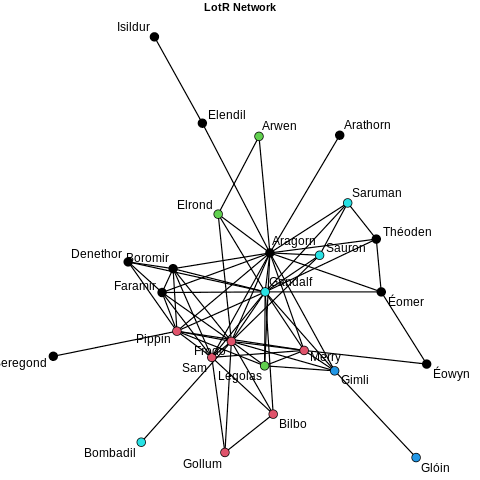

In [85]:
%%R
par(mfrow=c(1,1), mar=c(0,0,1,0))
set.seed(123)
plot(lotr.s, 
     main="LotR Network", 
     cex.main=0.9, 
     label=network.vertex.names(lotr.s),
     vertex.col='Subtype')

### [A simple Bernoulli ("Erdos/Renyi") model](http://statnet.org/Workshops/ergm_tutorial.html)

The syntax for specifying a model in the `ergm` package follows `R`’s formula convention:

`my.network ∼ my.vector.of.model.terms`

This syntax is used for both the `summary` and `ergm` functions. The `summary` function simply returns the numerical values of the network statistics in the model. The `ergm` function estimates the model with those statistics.

In [86]:
%%R
# View the g(y) statistic for this model
summary(lotr.s ~ edges)

# Fit the model
lotr.bern <- ergm(lotr.s ~ edges)

# View the fitted model object
summary(lotr.bern)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 



Call:
ergm(formula = lotr.s ~ edges)

Maximum Likelihood Results:

      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  -1.2747     0.1342      0  -9.495   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 450.5  on 325  degrees of freedom
 Residual Deviance: 341.2  on 324  degrees of freedom
 
AIC: 343.2  BIC: 347  (Smaller is better. MC Std. Err. = 0)


This simple model specifies a single homogeneous probability for all ties, which is captured by the coefficient of the `edges` term. We can interpret this coefficient by returning to the logit form of the ERGM. The log-odds that a tie is present is


$logit(p(y)) = \theta \times \delta(g(y))$

= -1.28 $\times$ change in the number of ties

= -1.28 $\times$ 1


for every tie, since the addition of any tie to the network always increases the total number of ties by 1.

The corresponding probability is obtained by taking the expit, or inverse logit, of $\theta$:

= exp(-1.28) / (1 + exp(-1.28)) = 0.218

In [87]:
%%R
plogis(coef(lotr.bern))

    edges 
0.2184615 


This probability corresponds to the density we observe in the `LotR` network: there are 71 ties and $26 \choose 2$ = (26 $\times$ 25) = 325 dyads, so the probability of a tie is 71 / 325 = 0.218.

In [88]:
%%R
lotr.ergm <- formula(lotr.s ~ edges
   + gwdsp(decay = log(3), fixed = TRUE)
   + nodemain("Gender")
   + match("Subtype"))

lotr.ergm

lotr.s ~ edges + gwdsp(decay = log(3), fixed = TRUE) + nodemain("Gender") + 
    match("Subtype")


### [Nodal covariate: Homophily](http://statnet.org/Workshops/ergm_tutorial.html)

Subtype may be associated with the connections in this network.  We can use `ergm` to test this.  Subtype is a discrete attribute, so we use the ergm-term `nodematch` to investigate homophily in connections by Subtype.

In [89]:
%%R
# Frequencies of Subtype
table(lotr.s %v% "Subtype")


 1  2  3  4  5 
11  6  3  2  4 


In [90]:
%%R
# View ties between Subtype categories
mixingmatrix(lotr.s, "Subtype")

   1  2  3  4  5
1 12 13  3  1  9
2 13 11  4  2  7
3  3  4  1  1  2
4  1  2  1  1  1
5  9  7  2  1  3


R[write to console]: Note:  Marginal totals can be misleading for undirected mixing matrices.



In [91]:
%%R
# View the g(y) statistic for this model

# When diff=FALSE, this term adds one network statistic to the model, 
# which counts the number of edges (i,j) for which attr(i)==attr(j). 
# This is also called ”uniform homophily,” because each group is assumed 
# to have the same propensity for within-group ties.
set.seed(619)
summary(lotr.s ~ edges + 
          nodefactor("Subtype") + 
          nodematch("Subtype", diff=FALSE))

               edges nodefactor.Subtype.2 nodefactor.Subtype.3 
                  71                   48                   12 
nodefactor.Subtype.4 nodefactor.Subtype.5    nodematch.Subtype 
                   7                   25                   28 


Here we fit the model with the `ergm` function.

In [92]:
%%R
# Fit the model

# When diff=FALSE, this term adds one network statistic to the model, 
# which counts the number of edges (i,j) for which attr(i)==attr(j). 
# This is also called ”uniform homophily,” because each group is assumed 
# to have the same propensity for within-group ties.
set.seed(619)
lotr.hom.formula <- formula(lotr.s ~ edges + 
                              nodefactor("Subtype") + 
                              nodematch("Subtype", diff=FALSE)) #levels=-c(2,5)

lotr.homophily <- ergm(lotr.hom.formula) #control=control.ergm(MCMLE.maxit = 30)

# View the model results
summary(lotr.homophily)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 



Call:
ergm(formula = lotr.hom.formula)

Maximum Likelihood Results:

                     Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                 -2.4635     0.3430      0  -7.183  < 1e-04 ***
nodefactor.Subtype.2   1.0137     0.2576      0   3.935  < 1e-04 ***
nodefactor.Subtype.3   0.2207     0.3591      0   0.615 0.538834    
nodefactor.Subtype.4   0.1234     0.4521      0   0.273 0.784831    
nodefactor.Subtype.5   0.7415     0.2971      0   2.496 0.012563 *  
nodematch.Subtype      1.2749     0.3426      0   3.722 0.000198 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 450.5  on 325  degrees of freedom
 Residual Deviance: 311.6  on 319  degrees of freedom
 
AIC: 323.6  BIC: 346.3  (Smaller is better. MC Std. Err. = 0)


By exponentiating the coefficients, they can be interpreted as a conditional log-odds ratio for interaction (ties) between people in the LotR network.  For example, being Hobbit rather than Men increases the odds of interaction by a factor of exp(1.0137) $\approx$ 2.76, or over 175% ("all else being equal").  Similarly, being of the same Subtype increases the odds of interaction by a factor of exp(1.275) $\approx$ 3.58, or over 250%.

In [93]:
%%R
# Subtype levels: men hobbit elves dwarf ainur

# Exponentiate the coefficients (conditional log-odds)
exp(coef(lotr.homophily))

# Inverse-logit the coefficients (conditional probabilities)
plogis(coef(lotr.homophily))

               edges nodefactor.Subtype.2 nodefactor.Subtype.3 
          0.07845745           0.73374671           0.55494995 
nodefactor.Subtype.4 nodefactor.Subtype.5    nodematch.Subtype 
          0.53081756           0.67732659           0.78158344 


The analysis of variance (ANOVA) table indicates that there is strong evidence that the variables used in the model explain the variation in network connectivity, with a decrease in residual deviance from 451 to 312 with only six variables.

In [94]:
%%R
anova(lotr.homophily)

Analysis of Variance Table

Model 1: lotr.s ~ edges + nodefactor("Subtype") + nodematch("Subtype", 
    diff = FALSE)
         Df Deviance Resid. Df Resid. Dev Pr(>|Chisq|)    
NULL                       325     450.55                 
Model 1:  6   138.91       319     311.64    < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### [Nodal covariates: Main and Second-order Effects](http://statnet.org/Workshops/ergm_tutorial.html)

Main effects and second-order (e.g. similarity or homophily effects) of node attributes can be incorporated into a `ergm` model with the terms `nodemain` and `nodematch`.  For example, we can evaluate whether gender has a "main" effect and subtype has a "second-order" effect on the formation of collaborative ties among people in the LotR network, while accounting for the effects of transitivity, with the following model specification.

In [95]:
%%R
lotr.ergm <- formula(lotr.s ~ gwesp(1, fixed = TRUE)
   + nodemain("Gender") 
   + nodematch("Subtype", diff=TRUE, levels=-c(4))
   )

# View the g(y) statistic for this model
# Subtype levels: men hobbit elves dwarf ainur
summary(lotr.ergm)

      gwesp.fixed.1      nodecov.Gender nodematch.Subtype.1 nodematch.Subtype.2 
            137.546             146.000              12.000              11.000 
nodematch.Subtype.3 nodematch.Subtype.5 
              1.000               3.000 


Here we fit the model with the `ergm` function.

In [96]:
%%R
set.seed(619)
lotr.ergm.fit <- ergm(lotr.ergm)
lotr.ergm.fit

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Starting Monte Carlo maximum likelihood estimation (MCMLE):

R[write to console]: Iteration 1 of at most 60:

R[write to console]: Optimizing with step length 0.4429.

R[write to console]: The log-likelihood improved by 2.2237.

R[write to console]: Estimating equations are not within tolerance region.

R[write to console]: Iteration 2 of at most 60:

R[write to console]: Optimizing with step length 0.2809.

R[write to console]: The log-likelihood improved by 7.0060.

R[write to console]: Estimating equations are not within tolerance region.

R[write to console]: Iteration 3 of at most 60:

R[write to console]: Optimizing with step length 0.1032.

R[write to console]: The log-likelihood improved by 2.2856.

R[write to console]: Estima


Call:
ergm(formula = lotr.ergm)

Last MCMC sample of size 1854 based on:
      gwesp.fixed.1       nodecov.Gender  nodematch.Subtype.1  
             0.7333              -1.6690               0.4291  
nodematch.Subtype.2  nodematch.Subtype.3  nodematch.Subtype.5  
             1.5615               2.7616               1.4497  

Monte Carlo Maximum Likelihood Coefficients:
      gwesp.fixed.1       nodecov.Gender  nodematch.Subtype.1  
             0.7321              -1.6688               0.4247  
nodematch.Subtype.2  nodematch.Subtype.3  nodematch.Subtype.5  
             1.5926               2.7573               1.3530  


When dyad dependent terms are in the model, the computational algorithms in `ergm` use MCMC (with a Metropolis-Hastings sampler) to estimate the parameters.  For these models, it is important to assess model convergence before interpreting the model results – before evaluating statistical significance, interpreting coefficients, or assessing goodness of fit.  To do this, we use the function `mcmc.diagnostics`.

Sample statistics summary:

Iterations = 25088:973824
Thinning interval = 512 
Number of chains = 1 
Sample size per chain = 1854 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                        Mean      SD Naive SE Time-series SE
gwesp.fixed.1        7.12295 56.8572  1.32048        4.06828
nodecov.Gender       5.39213 42.4370  0.98558        3.11875
nodematch.Subtype.1  0.62513  6.1429  0.14266        0.39485
nodematch.Subtype.2 -0.12729  2.3969  0.05567        0.12232
nodematch.Subtype.3  0.01348  0.7791  0.01809        0.02453
nodematch.Subtype.5  0.32093  1.6931  0.03932        0.08128

2. Quantiles for each variable:

                      2.5%    25%   50%   75% 97.5%
gwesp.fixed.1       -104.9 -32.93 10.42 47.93 108.8
nodecov.Gender       -83.0 -22.00 10.00 36.00  77.0
nodematch.Subtype.1  -10.0  -4.00  0.00  5.00  12.0
nodematch.Subtype.2   -6.0  -2.00  0.00  2.00   3.0
nodematch.Subtype.3   -1.0   0.00  0.00  0.00   2.

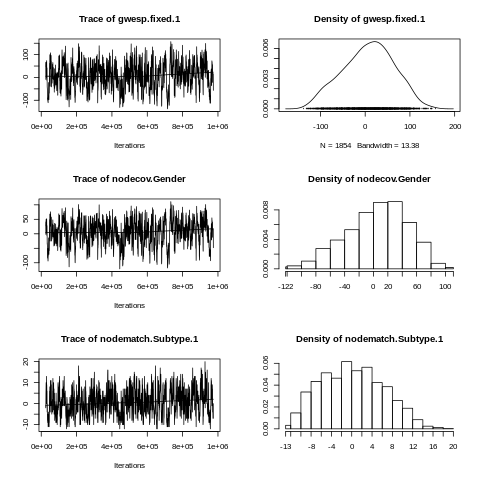

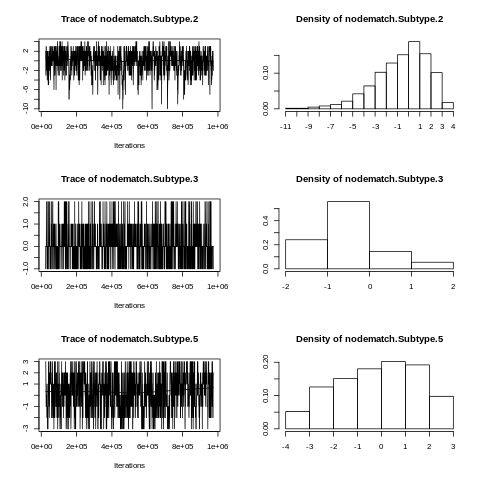

In [97]:
%%R
# View MCMC diagnostics
mcmc.diagnostics(lotr.ergm.fit)

Here we view the model results.

In [98]:
%%R
summary(lotr.ergm.fit)

Call:
ergm(formula = lotr.ergm)

Monte Carlo Maximum Likelihood Results:

                    Estimate Std. Error MCMC % z value Pr(>|z|)    
gwesp.fixed.1         0.7321     0.1185      0   6.177  < 1e-04 ***
nodecov.Gender       -1.6688     0.1648      0 -10.125  < 1e-04 ***
nodematch.Subtype.1   0.4247     0.2668      0   1.592 0.111354    
nodematch.Subtype.2   1.5926     0.4543      0   3.506 0.000455 ***
nodematch.Subtype.3   2.7573     1.3578      0   2.031 0.042282 *  
nodematch.Subtype.5   1.3530     0.6680      0   2.026 0.042814 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 450.5  on 325  degrees of freedom
 Residual Deviance: 269.7  on 319  degrees of freedom
 
AIC: 281.7  BIC: 304.4  (Smaller is better. MC Std. Err. = 0.3104)


By exponentiating the coefficients, they can be interpreted as a conditional log-odds ratio for interaction (ties) between people in the LotR network.  For example, being Female rather than Male decreases the odds of interaction by a factor of exp(-1.67) $\approx$ 0.19, or nearly 80% ("all else being equal").  Similarly, being of the same `Hobbit` Subtype increases the odds of interaction by a factor of exp(1.593) $\approx$ 4.92, or nearly 400%.  In addition, the coefficient and standard error for the alternating k-triangle statistic indicate there is evidence for a nontrivial transitivity effect.

In [99]:
%%R
# Subtype levels: men hobbit elves dwarf ainur

# Exponentiate the coefficients (conditional log-odds)
exp(coef(lotr.ergm.fit))

# Inverse-logit the coefficients (conditional probabilities)
plogis(coef(lotr.ergm.fit))

      gwesp.fixed.1      nodecov.Gender nodematch.Subtype.1 nodematch.Subtype.2 
          0.6752724           0.1585801           0.6046086           0.8309843 
nodematch.Subtype.3 nodematch.Subtype.5 
          0.9403261           0.7946200 


The analysis of variance (ANOVA) table indicates that there is strong evidence that the variables used in the model explain the variation in network connectivity, with a decrease in residual deviance from 563 to 335 with only six variables.

In [100]:
%%R
anova(lotr.ergm.fit)

Analysis of Variance Table

Model 1: lotr.s ~ gwesp(1, fixed = TRUE) + nodemain("Gender") + nodematch("Subtype", 
    diff = TRUE, levels = -c(4))
         Df Deviance Resid. Df Resid. Dev Pr(>|Chisq|)    
NULL                       325     450.55                 
Model 1:  6    180.9       319     269.65    < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


To assess the goodness-of-fit of ERGMs, the current practice is to simulate many random graphs from the fitted model and then compare several summary statistics of these graphs to those of the original graph.  If the summary statistics of the original graph don't match the typical values of the fitted random graphs, then this suggests systematic differences between the model and the data and a lack of goodness-of-fit.

In [101]:
%%R
gof.lotr.ergm <- gof(lotr.ergm.fit)
gof.lotr.ergm


Goodness-of-fit for degree 

         obs min mean max MC p-value
degree0    0   0 3.24   9       0.08
degree1    5   0 2.09   8       0.20
degree2    3   0 1.93   6       0.70
degree3    1   0 2.24   6       0.74
degree4    7   0 2.33   6       0.00
degree5    0   0 2.15   7       0.22
degree6    2   0 2.21   7       1.00
degree7    2   0 2.40   6       1.00
degree8    1   0 1.95   7       0.86
degree9    1   0 1.77   7       1.00
degree10   1   0 1.36   6       1.00
degree11   0   0 0.89   4       1.00
degree12   0   0 0.68   4       1.00
degree13   0   0 0.36   2       1.00
degree14   1   0 0.22   3       0.38
degree15   0   0 0.12   2       1.00
degree16   1   0 0.04   1       0.08
degree17   1   0 0.02   1       0.04

Goodness-of-fit for edgewise shared partner 

      obs min  mean max MC p-value
esp0    8   0  4.29  13       0.26
esp1    2   0  9.35  23       0.12
esp2   12   0 13.70  25       0.86
esp3   13   0 14.42  28       0.90
esp4    7   0 11.71  32       0.56
esp5   11 

We can plot the results of the `gof` function.  The results show that the model fit is moderate.  The observed summary statistics are within the IQR of the simulated values in most cases (except for Subtype 3).

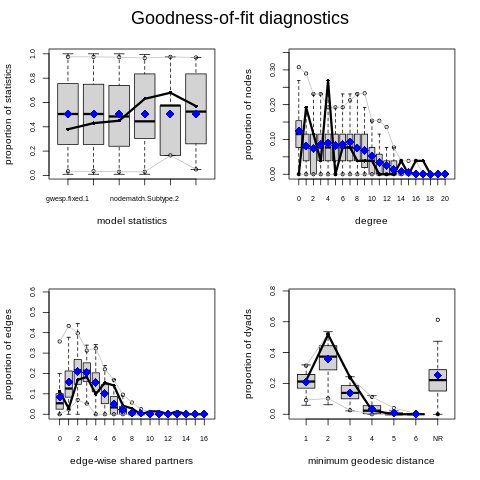

In [102]:
%%R
# fig.width = 6, fig.asp = 0.618
par(mfrow = c(2,2))
plot(gof.lotr.ergm)

# References

1. Filippo Menczer, Santo Fortunato, and Clayton Davis. [A First Course in Network Science](https://cambridgeuniversitypress.github.io/FirstCourseNetworkScience/). Cambridge University Press, 2020.

2. Eric Kolaczyk and Gabor Csardi. [Statistical Analysis of Network Data with R, 2nd Edition](https://github.com/kolaczyk/sand). Springer, 2020.

3. Mark Newman. [Networks, 2nd Edition](https://www.amazon.com/Networks-Mark-Newman-dp-0198805098/dp/0198805098/). Oxford University Press, 2018.

4. Matthew Jackson. [Social and Economic Networks](https://www.coursera.org/learn/social-economic-networks). Princeton University Press, 2008.

5. Matthew Jackson. [The Human Network: How Your Social Position Determines Your Power, Beliefs, and Behaviors](https://web.stanford.edu/~jacksonm/books.html). Vintage Books, 2020.

6. David Easley and Jon Kleinberg. [Networks, Crowds, and Markets: Reasoning about a Highly Connected World](https://www.cs.cornell.edu/home/kleinber/networks-book/). Cambridge University Press, 2010.